In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Permute,Flatten
from keras import optimizers, Input, Model
from attention import Attention
from keras.callbacks import ModelCheckpoint
from sklearn.svm import NuSVR, SVR
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
import warnings
import itertools
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size':20})

Using TensorFlow backend.


In [2]:
input_dim =12
output_dim = 12
train_data = pd.read_excel('underwater_rawdata/underwater.xlsx')
data_daman = np.array(train_data['daman-obs'])
data_ynzw = np.array(train_data['yanuan-obs'])
data_banqiao = np.array(train_data['banqiao-obs'])
data_liaoquan = np.array(train_data['liaoquan-obs'])
data_22 = np.array(train_data['22-obs'])
data_luocheng = np.array(train_data['luocheng-obs'])
# data_yingluo = np.array(train_data['yingluo'])
# data_liyuan = np.array(train_data['liyuan'])
# data_zhengyi = np.array(train_data['zhengyi'])
# data_gao = np.array(train_data['gaoya'])
# data = np.stack((data_daman,data_ynzw,data_banqiao,data_liaoquan,data_luocheng,data_22, data_yingluo, data_liyuan, data_zhengyi, data_gao),axis=1)
data = np.stack((data_daman,data_ynzw,data_banqiao,data_liaoquan,data_luocheng,data_22),axis=1)

scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)
test_x,test_y = [],[]
for i in range(251, 252):
    test_x.append(data_scaled[i:i+input_dim])
    test_y.append((data_22[i+input_dim:i+input_dim+output_dim]-min(data_22))*100)
test_x = np.array(test_x)
test_y = np.array(test_y).reshape(-1, 12, 1)
X_train,y_train = [],[]
for i in range(251):
    X_train.append(data_scaled[i:i+input_dim])
    y_train.append((data_22[i+input_dim:i+input_dim+output_dim]-min(data_22))*100)    
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 12, 1)
X_data,y_data = [],[]
for i in range(252):
    X_data.append(data_scaled[i:i+input_dim])
    y_data.append((data_22[i+input_dim:i+input_dim+output_dim]-min(data_22))*100)    
X_data = np.array(X_data)
y_data = np.array(y_data)

In [ ]:
p = range(0, 3)
d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print(len(pdq), len(seasonal_pdq))

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
min_aic = 0
min_text = ''
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data_22[:-12],
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if results.aic < min_aic:
            min_aic = results.aic
            min_text = str(param) + ' ' + str(param_seasonal)

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
print(min_aic)
print(min_text)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(data_22[:-12],
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
 
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=264, end=275, dynamic=False)
arima_test = pred.predicted_mean
plt.figure()
plt.plot(arima_test,'r',label = ' predict')
plt.plot(data_22[-12:], 'b',label = 'real')
plt.legend()
plt.show()
raw_data = data_22[-12:]
testPredict = pred.predicted_mean
mae_score = mean_absolute_error(raw_data, testPredict)
rmse_score = rmse(raw_data, testPredict)
r2_res = r2_score(raw_data, testPredict)
print(' MAE Score: '+str(mae_score))
print(' RMSE Score: '+str(rmse_score))
print(' R2 Score:' + str(r2_res))

In [9]:
X_train.shape

(251, 12, 6)

In [10]:
test_x.shape

(1, 12, 6)

In [5]:
from seq2seq_model.seq2seq import seq2seq
from seq2seq_model.seq2seq_attention_2 import seq2seq_attention

In [11]:
time_step = 12
feature_len = 6
after_day = 12
feature_output = 1
units_num = 128
input_shape = (time_step, feature_len)
model_seq2seq_attention = seq2seq_attention(feature_len, after_day, units_num, feature_output, input_shape, time_step)
model_seq2seq_attention.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 6)        0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 12, 128), (N 69120       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 12, 128)      0           encoder[0][1]                    
                                                                 decoder[0][1]                    
                                                                 decoder[1][1]                    
                                                                 decoder[2][1]              

In [13]:
# from keras.callbacks import ModelCheckpoint
adam = optimizers.Adam(lr=0.0003)
model_seq2seq_attention.compile(loss='mean_squared_error', optimizer=adam)
# filepath="model_save/model_attention.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
attention_hostory = model_seq2seq_attention.fit(X_train, y_train, epochs=100)

Epoch 1/100
251/251 [==============================] - 8s 32ms/step - loss: 644.4916
Epoch 2/100
251/251 [==============================] - 1s 2ms/step - loss: 639.1222
Epoch 3/100
251/251 [==============================] - 1s 2ms/step - loss: 631.6640
Epoch 4/100
251/251 [==============================] - 1s 2ms/step - loss: 625.4824
Epoch 5/100
251/251 [==============================] - 1s 2ms/step - loss: 618.0338
Epoch 6/100
251/251 [==============================] - 1s 2ms/step - loss: 608.7555
Epoch 7/100
251/251 [==============================] - 1s 2ms/step - loss: 594.5843
Epoch 8/100
251/251 [==============================] - 1s 2ms/step - loss: 571.0821
Epoch 9/100
251/251 [==============================] - 1s 2ms/step - loss: 544.2340
Epoch 10/100
251/251 [==============================] - 1s 2ms/step - loss: 527.3327
Epoch 11/100
251/251 [==============================] - 1s 2ms/step - loss: 516.6189
Epoch 12/100
251/251 [==============================] - 1s 2ms/step - los

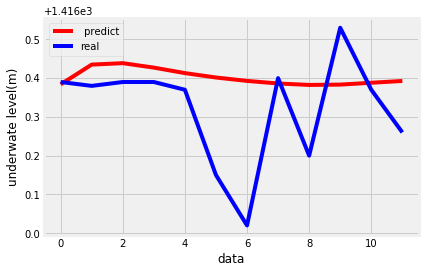

 MAE Score: 0.1089851888020803
 RMSE Score: 0.15380674612397066
 R2 Score:-0.3473631222825524


In [14]:
# from keras.models import load_model
# model_seq2seq_attention = load_model("model_save/model_attention.hdf5")
predict_res = model_seq2seq_attention.predict(test_x)
testPredict = np.array(predict_res).reshape(-1, 12)[-1]
plt.plot(testPredict/100 + min(data_22),'r',label = ' predict')
raw_data = data_22[-len(testPredict)-0:]
plt.plot(range(len(testPredict)), raw_data,'b',label = 'real')
plt.xlabel('data')
plt.ylabel('underwate level(m)')
plt.legend()
plt.show()
mae_score = mean_absolute_error(raw_data, testPredict/100 + min(data_22))
rmse_score = rmse(raw_data, testPredict/100 + min(data_22))
r2_res = r2_score(raw_data, testPredict/100 + min(data_22))
print(' MAE Score: '+str(mae_score))
print(' RMSE Score: '+str(rmse_score))
print(' R2 Score:' + str(r2_res))

In [33]:
test_predict_12 = predict_res

In [17]:
def inverse_list(alist):
    return alist/100 + min(data_22)
inverse_list(np.array([75.007225, 76.29854 , 74.54523 , 73.41277 , 64.733685, 46.490265,
        39.652107, 56.69607 , 86.2207  , 90.02416 , 87.85568 , 80.17305 ]))

array([1416.38007225, 1416.3929854 , 1416.3754523 , 1416.3641277 ,
       1416.27733685, 1416.09490265, 1416.02652107, 1416.1969607 ,
       1416.492207  , 1416.5302416 , 1416.5085568 , 1416.4317305 ])

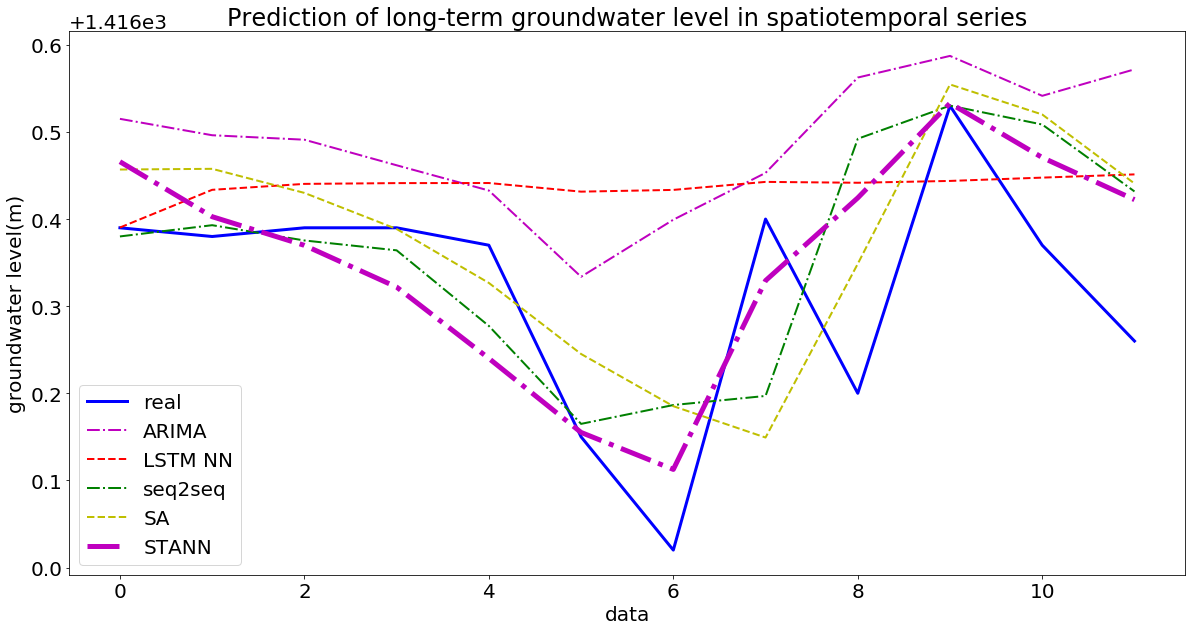

ARIMA MAE Score: 0.16636058166667075
ARIMA RMSE Score: 0.202133602014455
ARIMA R2 Score: -1.3270778788595172
ANN MAE Score: 0.13012499999996407
ANN RMSE Score: 0.17645996477009762
ANN R2 Score: -0.7734798718504543
LSTM MAE Score: 0.09526626833333769
LSTM RMSE Score: 0.13322453022223435
LSTM R2 Score: -0.010886233921042932
LSTM+attention MAE Score: 0.10371388333332258
LSTM+attention RMSE Score: 0.12621441558359897
LSTM+attention R2 Score: 0.09269812405185573
STANN MAE Score: 0.0812885233333418
STANN RMSE Score: 0.10352720131027439
STANN R2 Score: 0.3895602091508761


In [9]:
def inverse_list(alist):
    return alist/100 + min(data_22)
# 此处数据为为了画图方便，最优模型复制过来的。训练过程需要调参，epoch、lr等
arima_test = np.array([1416.51506988, 1416.49625748, 1416.49111747, 1416.46177291,
       1416.43278908, 1416.33378201, 1416.39928331, 1416.45304101,
       1416.56248966, 1416.58732499, 1416.5415149 , 1416.57188428])
lstmnn_test =  [1416.3903, 1416.4336, 1416.4404, 1416.4413, 1416.4414, 1416.4315, 1416.4335,
 1416.4427, 1416.4417, 1416.4438, 1416.4476, 1416.4513]
seq2seq_test = [1416.38007225, 1416.3929854 , 1416.3754523 , 1416.3641277 ,
       1416.27733685, 1416.16490265, 1416.18652107, 1416.1969607 ,
       1416.492207  , 1416.5302416 , 1416.5085568 , 1416.4317305 ]
attention_test = [1416.4568895, 1416.4576966, 1416.4300576, 1416.3886355,
       1416.3267036, 1416.245128 , 1416.1852112, 1416.1492051,
       1416.3486815, 1416.5545573, 1416.5200543, 1416.4408348]
muti_attention_test =[1416.46588594, 1416.40275808, 1416.36985785, 1416.32194231,
       1416.24008332, 1416.15505561, 1416.11263352, 1416.32935312,
       1416.42435088, 1416.5330225 , 1416.47067718, 1416.42231517]

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size':20})
plt.plot(range(12),data_22[-12:],'b',label = 'real', linewidth = '3')
plt.plot(arima_test,'m-.',label = 'ARIMA', linewidth = '2')
plt.plot(lstmnn_test,'r--',label = 'LSTM NN', linewidth = '2')
plt.plot(seq2seq_test,'g-.',label = 'seq2seq', linewidth = '2')
plt.plot(attention_test,'y--',label = 'SA', linewidth = '2')
plt.plot(muti_attention_test,'m-.',label = 'STANN', linewidth = '5')

plt.xlabel('data')
plt.ylabel('groundwater level(m)')
plt.title('Prediction of long-term groundwater level in spatiotemporal series')
plt.legend()
plt.show()

def get_result(model_res,title):
    mae_score = mean_absolute_error(data_22[-12:], model_res)
    rmse_score = rmse(data_22[-12:], model_res)
    r2 = r2_score(data_22[-12:], model_res)
    print(str(title)+' MAE Score: '+str(mae_score))
    print(str(title)+' RMSE Score: '+str(rmse_score))
    print(str(title)+' R2 Score: '+str(r2))
get_result(arima_test,'ARIMA')
get_result(lstmnn_test,'ANN')
get_result(seq2seq_test,'LSTM')
get_result(attention_test,'LSTM+attention')
get_result(muti_attention_test,'STANN')